# Setup

In [1]:
!pip install "numpy<1.20"
import pandas as pd
import numpy as np
import string
import seaborn as sns
!pip install -U scikit-multiflow
#!pip install git+https://github.com/kushvarma/scikit-multiflow.git
#resource for profanity: https://pypi.org/project/profanity-check/
!pip install alt-profanity-check
!pip install sklearn --upgrade
#resource for sentiment: https://realpython.com/python-nltk-sentiment-analysis/#using-nltks-pre-trained-sentiment-analyzer
!pip install nltk
from profanity_check import predict
import nltk
nltk.download([
"names",
"stopwords",
"state_union",
"twitter_samples",
"movie_reviews",
"averaged_perceptron_tagger",
"vader_lexicon",
"punkt"])
from nltk.sentiment import SentimentIntensityAnalyzer
import matplotlib
%matplotlib notebook
#from google.colab import drive
#drive.mount('/content/drive')
!pip install tensorflow-io
from sklearn.model_selection import train_test_split
import tensorflow as tf

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://github.com/scikit-learn/sklearn-pypi-packag

[nltk_data] Downloading package names to
[nltk_data]     C:\Users\aztec\AppData\Roaming\nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aztec\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package state_union to
[nltk_data]     C:\Users\aztec\AppData\Roaming\nltk_data...
[nltk_data]   Package state_union is already up-to-date!
[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\aztec\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\aztec\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\aztec\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [2]:
from sklearn import preprocessing

# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd

from collections.abc import Sequence
# Split into train/test
from sklearn.model_selection import train_test_split
# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Tweet Feature Extraction And Data Cleaning/Processing

In [3]:
ah_tweets = pd.read_csv("../hatespeech_text_label_vote_RESTRICTED_100K_v2.csv")
#had to fix dataframe column names
ah_tweets = ah_tweets.rename(columns={"Tweet text  Label   Votes for the majority label": "Tweet text", "Unnamed: 1": "Label", "Unnamed: 2": "Votes for the majority label"})
#last column not needed
ah_tweets.drop(ah_tweets.columns[[2]], axis=1, inplace=True)
#"spam" labels not needed
ah_tweets = ah_tweets[ah_tweets['Label'] != "spam"]

In [4]:
ah_tweets

,Tweet text,Label
1,RT @Papapishu: Man it would fucking rule if we...,abusive
2,It is time to draw close to Him &#128591;&#127...,normal
3,if you notice me start to act different or dis...,normal
4,"Forget unfollowers, I believe in growing. 7 ne...",normal
5,RT @Vitiligoprince: Hate Being sexually Frustr...,abusive
...,...,...
99991,RT @shangros: my fucking queen https://t.co/wa...,abusive
99992,#Osteporosis treated with #PEMF - rebuild bone...,normal
99993,@LGUSAMobile why does my phone screen keeps fl...,normal
99994,#bigdata vs. #reality ... but equally applies ...,normal


In [5]:
ah_tweets["@ count"] = ah_tweets['Tweet text'].str.count('@')
#Remove @'s from tweet text
ah_tweets['Tweet text'] = ah_tweets['Tweet text'].str.replace('@[\S]*', '')

ah_tweets['Hashtag count'] = ah_tweets['Tweet text'].str.count('#')
#Remove #'s from tweet text
ah_tweets['Tweet text'] = ah_tweets['Tweet text'].str.replace('#[\S]*','')

ah_tweets['Retweet'] = ah_tweets['Tweet text'].str.contains('RT')
#Remove RT's from tweet text
ah_tweets['Tweet text'] = ah_tweets['Tweet text'].str.replace('RT', '')

ah_tweets['Url count'] = ah_tweets['Tweet text'].str.count('http[\S]*')
#Remove URL's from tweet text
ah_tweets['Tweet text'] = ah_tweets['Tweet text'].str.replace('http[\S]*','')

ah_tweets['Uppercase word count'] = ah_tweets['Tweet text'].apply(lambda x: sum(map(str.isupper, x.split())))

ah_tweets['Num sentences'] = ah_tweets['Tweet text'].apply(lambda x: len(nltk.sent_tokenize(x)))

ah_tweets['temp'] = ah_tweets['Tweet text'].apply(lambda x: nltk.sent_tokenize(x))
ah_tweets['Avg sentence len'] = ah_tweets['temp'].apply(lambda x: pd.Series(x).apply(lambda y: len(nltk.word_tokenize(y))).mean())
ah_tweets.drop(ah_tweets.columns[[8]], axis=1, inplace=True)

#Got rid of ah_tweets with no text information after data cleaning/processing
ah_tweets['Text empty'] = ah_tweets['Tweet text'].apply(lambda x: x.isspace())
ah_tweets = ah_tweets[ah_tweets['Text empty'] != True]
ah_tweets.drop(ah_tweets.columns[[9]], axis=1, inplace=True)
ah_tweets['Text empty'] = ah_tweets['Tweet text'].apply(lambda x: len(x) == 0)
ah_tweets = ah_tweets[ah_tweets['Text empty'] != True]
ah_tweets.drop(ah_tweets.columns[[9]], axis=1, inplace=True)

<ipython-input-5-e4e02b169367>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  ah_tweets['Tweet text'] = ah_tweets['Tweet text'].str.replace('@[\S]*', '')
<ipython-input-5-e4e02b169367>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  ah_tweets['Tweet text'] = ah_tweets['Tweet text'].str.replace('#[\S]*','')
<ipython-input-5-e4e02b169367>:15: FutureWarning: The default value of regex will change from True to False in a future version.
  ah_tweets['Tweet text'] = ah_tweets['Tweet text'].str.replace('http[\S]*','')
<ipython-input-5-e4e02b169367>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  ah_tweets['Avg sentence len'] = ah_tweets['temp'].apply(lambda x: pd.Series(x).apply(lambda y: len(nltk.word_tokenize(y))).mean())
c:\Users\aztec\anaconda3\lib\site-packages\pan

In [6]:
sia = SentimentIntensityAnalyzer() #Sentiment is 'compound' value from -1 to 1
ah_tweets['Sentiment'] = ah_tweets['Tweet text'].apply(lambda x: sia.polarity_scores(x)['compound'])

#Create temperorary parts of speech column
from collections import Counter
ah_tweets['temp'] = ah_tweets['Tweet text'].apply(lambda x: nltk.pos_tag(x.split()))
ah_tweets['temp'] = ah_tweets['temp'].apply(lambda x: Counter(tag for word,tag in x))

#Counting all adjectives
ah_tweets['Adjective count'] = ah_tweets['temp'].apply(lambda x: x['JJ'])
ah_tweets['Adjective count'] = ah_tweets['Adjective count'] + ah_tweets['temp'].apply(lambda x: x['JJR'])
ah_tweets['Adjective count'] = ah_tweets['Adjective count'] + ah_tweets['temp'].apply(lambda x: x['JJS'])

#Counting all verbs
ah_tweets['Verb count'] = ah_tweets['temp'].apply(lambda x: x['VB'])
ah_tweets['Verb count'] = ah_tweets['Verb count'] + ah_tweets['temp'].apply(lambda x: x['VBP'])
ah_tweets['Verb count'] = ah_tweets['Verb count'] + ah_tweets['temp'].apply(lambda x: x['VBD'])
ah_tweets['Verb count'] = ah_tweets['Verb count'] + ah_tweets['temp'].apply(lambda x: x['VBG'])
ah_tweets['Verb count'] = ah_tweets['Verb count'] + ah_tweets['temp'].apply(lambda x: x['VBN'])
ah_tweets['Verb count'] = ah_tweets['Verb count'] + ah_tweets['temp'].apply(lambda x: x['VBZ'])

#Counting all adverbs
ah_tweets['Adverb count'] = ah_tweets['temp'].apply(lambda x: x['RB'])
ah_tweets['Adverb count'] = ah_tweets['Adverb count'] + ah_tweets['temp'].apply(lambda x: x['RBR'])
ah_tweets['Adverb count'] = ah_tweets['Adverb count'] + ah_tweets['temp'].apply(lambda x: x['RBS'])

#Remove temperoary parts of speech column
ah_tweets.drop(ah_tweets.columns[[10]], axis=1, inplace=True)

#Remove punctuation from tweet text
ah_tweets['Tweet text'] = ah_tweets['Tweet text'].str.replace('[^\w\s]', '')
#Remove numbers from tweet text
ah_tweets['Tweet text'] = ah_tweets['Tweet text'].str.replace('\d', '')
#Remove non-letters from tweet text
ah_tweets['Tweet text'] = ah_tweets['Tweet text'].str.replace('[^a-zA-Z]', ' ')

#Got rid of ah_tweets with no text information after data cleaning/processing
ah_tweets['Text empty'] = ah_tweets['Tweet text'].apply(lambda x: x.isspace())
ah_tweets = ah_tweets[ah_tweets['Text empty'] != True]
ah_tweets.drop(ah_tweets.columns[[13]], axis=1, inplace=True)
ah_tweets['Text empty'] = ah_tweets['Tweet text'].apply(lambda x: len(x) == 0)
ah_tweets = ah_tweets[ah_tweets['Text empty'] != True]
ah_tweets.drop(ah_tweets.columns[[13]], axis=1, inplace=True)

ah_tweets['Profanity count'] = ah_tweets['Tweet text'].str.replace('\W', ' ').str.split()
ah_tweets['Profanity count'] = ah_tweets['Profanity count'].apply(lambda x: sum(predict(x)))

ah_tweets['Avg word len'] = ah_tweets['Tweet text'].apply(lambda x: sum(list(map(len,x.split()))) / len(x.split()))

<ipython-input-6-b4c6cbbd29cf>:31: FutureWarning: The default value of regex will change from True to False in a future version.
  ah_tweets['Tweet text'] = ah_tweets['Tweet text'].str.replace('[^\w\s]', '')
<ipython-input-6-b4c6cbbd29cf>:33: FutureWarning: The default value of regex will change from True to False in a future version.
  ah_tweets['Tweet text'] = ah_tweets['Tweet text'].str.replace('\d', '')
<ipython-input-6-b4c6cbbd29cf>:35: FutureWarning: The default value of regex will change from True to False in a future version.
  ah_tweets['Tweet text'] = ah_tweets['Tweet text'].str.replace('[^a-zA-Z]', ' ')
<ipython-input-6-b4c6cbbd29cf>:45: FutureWarning: The default value of regex will change from True to False in a future version.
  ah_tweets['Profanity count'] = ah_tweets['Tweet text'].str.replace('\W', ' ').str.split()


In [7]:
ah_tweets_copy = ah_tweets.copy()
ah_tweets

,Tweet text,Label,@ count,Hashtag count,Retweet,Url count,Uppercase word count,Num sentences,Avg sentence len,Sentiment,Adjective count,Verb count,Adverb count,Profanity count,Avg word len
1,Man it would fucking rule if we had a party ...,abusive,1,0,True,0,0,1,16.0,0.1280,1,3,0,1,4.266667
2,It is time to draw close to Him Father I draw...,normal,0,2,False,1,1,1,20.0,0.0000,0,4,3,0,3.294118
3,if you notice me start to act different or dis...,normal,0,0,False,0,0,1,35.0,0.0000,5,8,0,0,3.633333
4,Forget unfollowers I believe in growing new f...,normal,0,0,False,1,1,3,6.0,-0.1260,3,1,0,0,4.714286
5,Hate Being sexually Frustrated Like I wanna ...,abusive,1,0,True,0,1,1,16.0,-0.8689,0,2,1,3,4.785714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99991,my fucking queen,abusive,1,0,True,1,0,1,3.0,0.0000,0,0,0,1,4.666667
99992,treated with rebuild bone mass,normal,0,3,False,2,0,1,7.0,0.0000,0,1,0,0,5.200000
99993,why does my phone screen keeps flickring im s...,normal,1,4,False,0,0,1,29.0,-0.9430,4,4,2,1,3.576923
99994,vs but equally applies to any project,normal,0,3,False,2,0,1,8.0,0.0000,0,0,1,0,4.428571


In [8]:
ah_tweets.drop(ah_tweets.columns[[0]], axis=1, inplace=True)
category = encode_text_index(ah_tweets, "Label")
#'abusive' ah_tweets label = 0
#'hateful' ah_tweets label = 1
#'normal' ah_tweets label = 2
encode_numeric_zscore(ah_tweets, "@ count")
encode_numeric_zscore(ah_tweets, "Hashtag count")
encode_text_dummy(ah_tweets, "Retweet")
encode_numeric_zscore(ah_tweets, "Url count")
encode_numeric_zscore(ah_tweets, "Uppercase word count")
encode_numeric_zscore(ah_tweets, "Num sentences")
encode_numeric_zscore(ah_tweets, "Adjective count")
encode_numeric_zscore(ah_tweets, "Verb count")
encode_numeric_zscore(ah_tweets, "Adverb count")
encode_numeric_zscore(ah_tweets, "Profanity count")
encode_numeric_zscore(ah_tweets, "Avg sentence len")
encode_numeric_zscore(ah_tweets, "Avg word len")
ah_tweets

,Label,@ count,Hashtag count,Url count,Uppercase word count,Num sentences,Avg sentence len,Sentiment,Adjective count,Verb count,Adverb count,Profanity count,Avg word len,Retweet-False,Retweet-True
1,0,0.220582,-0.392741,-1.026551,-0.402188,-0.632783,0.426530,0.1280,-0.067988,0.163446,-0.696501,0.327584,-0.207162,0,1
2,2,-0.700879,0.862444,0.558705,-0.008264,-0.632783,1.044533,0.0000,-0.965360,0.695128,2.521878,-0.712615,-1.184764,1,0
3,2,-0.700879,-0.392741,-1.026551,-0.402188,-0.632783,3.362042,0.0000,3.521502,2.821852,-0.696501,-0.712615,-0.843786,1,0
4,2,-0.700879,-0.392741,0.558705,-0.008264,1.782263,-1.118476,-0.1260,1.726757,-0.899916,-0.696501,-0.712615,0.242782,1,0
5,0,0.220582,-0.392741,-1.026551,-0.008264,-0.632783,0.426530,-0.8689,-0.965360,-0.368235,0.376292,2.407981,0.314582,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99991,0,0.220582,-0.392741,0.558705,-0.402188,-0.632783,-1.581978,0.0000,-0.965360,-1.431597,-0.696501,0.327584,0.194916,0,1
99992,2,-0.700879,1.490037,2.143961,-0.402188,-0.632783,-0.963975,0.0000,-0.965360,-0.899916,-0.696501,-0.712615,0.731020,1,0
99993,2,0.220582,2.117630,-1.026551,-0.402188,-0.632783,2.435038,-0.9430,2.624130,0.695128,1.449085,0.327584,-0.900490,1,0
99994,2,-0.700879,1.490037,2.143961,-0.402188,-0.632783,-0.809475,0.0000,-0.965360,-1.431597,0.376292,-0.712615,-0.044416,1,0


# Create A/H Tweets Data Stream

In [9]:
x_ah = ah_tweets.iloc[:,1:]
y_ah = ah_tweets['Label']
x_train_ah, x_test_ah, y_train_ah, y_test_ah = train_test_split(x_ah, y_ah, test_size=0.3, random_state=42)
from skmultiflow.data import DataStream

# A/H Extremely Fast Decision Tree Model

In [10]:
from skmultiflow.trees import ExtremelyFastDecisionTreeClassifier
efdt = ExtremelyFastDecisionTreeClassifier()
efdt_text = ExtremelyFastDecisionTreeClassifier()

##### EFDT Hyperparameter Tuning

In [21]:
from sklearn.model_selection import ParameterGrid
efdt_params = [{"leaf_prediction": ["nba","mc","nb"],"split_criterion": ["info_gain","gini"], 
              "min_samples_reevaluate":[10,20,30], "grace_period": [100,200,300,400,500],
              "split_confidence":[.0000001,.00001,.001,.1],"tie_threshold": [.01,.025,.05,.075,.1]}]
efdt_gs = ParameterGrid(efdt_params)

In [28]:
len(efdt_gs)

18

In [29]:
from sklearn import metrics
#hyperparameter tuning
best_f1_score = 0
best_params = []
for params in efdt_gs:
    ah_tweet_stream = DataStream(data = x_ah, y = y_ah.values, cat_features=[12,13])
    temp_efdt = ExtremelyFastDecisionTreeClassifier()
    temp_efdt.set_params(grace_period = 500, split_criterion=params['split_criterion'],
        split_confidence=.1, tie_threshold=.075,
        leaf_prediction=params['leaf_prediction'], min_samples_reevaluate=params['min_samples_reevaluate'],
        nominal_attributes=[12,13])
    y_true = []
    y_pred_array = []
    # Train the estimator with the samples provided by the data stream
    while ah_tweet_stream.has_more_samples():
        X, y = ah_tweet_stream.next_sample()
        y_true.append(y)
        y_pred = temp_efdt.predict(X)
        y_pred_array.append(y_pred)
        temp_efdt.partial_fit(X, y)
    #ah_tweet_stream = DataStream(data = x_ah, y = y_ah.values, cat_features=[12,13])
    temp_f1 = metrics.f1_score(y_true, y_pred_array, average='weighted')
    if temp_f1 >= best_f1_score:
        best_f1_score = temp_f1
        best_params = params

In [30]:
best_params

{'leaf_prediction': 'mc',
 'min_samples_reevaluate': 20,
 'split_criterion': 'info_gain'}

##### EFDT Tweet Characteristic Model

In [11]:
y_true = []
y_pred_array = []
efdt.set_params(grace_period = 500, split_criterion='info_gain',
        split_confidence=.1, tie_threshold=.075,
        leaf_prediction='mc', min_samples_reevaluate=20,
        nominal_attributes=[12,13])
ah_tweet_stream = DataStream(data = x_ah, y = y_ah.values, cat_features=[12,13])
# Train the estimator with the samples provided by the data stream
while ah_tweet_stream.has_more_samples():
    X, y = ah_tweet_stream.next_sample()
    y_true.append(y)
    y_pred = efdt.predict(X)
    y_pred_array.append(y_pred)
    efdt.partial_fit(X, y)

In [12]:
from sklearn import metrics
print(metrics.classification_report(y_true, y_pred_array))

              precision    recall  f1-score   support

           0       0.74      0.91      0.82     27141
           1       0.08      0.00      0.00      4963
           2       0.93      0.90      0.91     53650

    accuracy                           0.85     85754
   macro avg       0.58      0.61      0.58     85754
weighted avg       0.82      0.85      0.83     85754



[[24833    10  2298]
 [ 3409     1  1553]
 [ 5239     1 48410]]


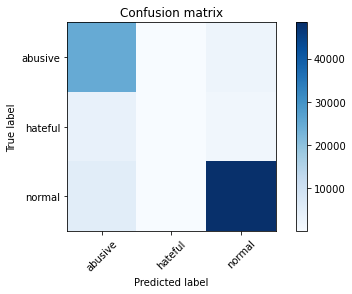

In [13]:
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
%matplotlib inline
import matplotlib.pyplot as plt

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_array)
print(cm)
plt.figure()
plot_confusion_matrix(cm, category)
plt.show()

##### EFDT Tweet Text Model

In [11]:
%pip install transformers
%pip install -U sentence-transformers

from sentence_transformers import SentenceTransformer

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
tweets_enum = model.encode(ah_tweets_copy['Tweet text'].values)

ah_text_stream = DataStream(data = tweets_enum, y = y_ah.values)

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: pyyaml>=5.1 in c:\users\aztec\anaconda3\lib\site-packages (from transformers) (5.4.1)



DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


Note: you may need to restart the kernel to use updated packages.


In [16]:
from skmultiflow.bayes import NaiveBayes
nb = NaiveBayes()
y_true = []
y_pred_array = []
ah_text_stream = DataStream(data = tweets_enum, y = y_ah.values)
# Train the estimator with the samples provided by the data stream
while ah_text_stream.has_more_samples():
    X, y = ah_text_stream.next_sample()
    y_true.append(y)
    y_pred = efdt_text.predict(X)
    y_pred_array.append(y_pred)
    efdt_text.partial_fit(X, y)

c:\Users\aztec\anaconda3\lib\site-packages\skmultiflow\bayes\utils.py:36: RuntimeWarning: overflow encountered in double_scalars
  votes[class_index] *= obs.probability_of_attribute_value_given_class(
c:\Users\aztec\anaconda3\lib\site-packages\skmultiflow\utils\utils.py:62: RuntimeWarning: invalid value encountered in double_scalars
  dictionary[key] = value / factor


In [15]:
from sklearn import metrics
print(metrics.classification_report(y_true, y_pred_array))

ValueError: max() arg is an empty sequence

In [11]:
%pip install transformers
%pip install -U sentence-transformers

from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import LabelEncoder

def fit_multiple_estimators(classifiers, X_list, y, sample_weights = None):

    # Convert the labels `y` using LabelEncoder, because the predict method is using index-based pointers
    # which will be converted back to original data later.
    le_ = LabelEncoder()
    le_.fit(y)
    transformed_y = le_.transform(y)

    # Fit all estimators with their respective feature arrays
    estimators_ = [clf.fit(X, y) if sample_weights is None else clf.fit(X, y, sample_weights) for clf, X in zip([clf for _, clf in classifiers], X_list)]

    return estimators_, le_


def predict_from_multiple_estimator(estimators, label_encoder, X_list, weights = None):

    # Predict 'soft' voting with probabilities

    pred1 = np.asarray([clf.predict_proba(X) for clf, X in zip(estimators, X_list)])
    pred2 = np.average(pred1, axis=0, weights=weights)
    pred = np.argmax(pred2, axis=1)

    # Convert integer predictions to original labels:
    return label_encoder.inverse_transform(pred)

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


Note: you may need to restart the kernel to use updated packages.


DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [12]:
model = SentenceTransformer('sentence-transformers/paraphrase-TinyBERT-L6-v2')

tweets_enum = model.encode(ah_tweets_copy['Tweet text'].values)

ah_text_stream = DataStream(data = tweets_enum, y = y_ah.values)

In [13]:
from skmultiflow.bayes import NaiveBayes
nb = NaiveBayes()
y_true = []
y_pred_array = []
ah_text_stream = DataStream(data = tweets_enum, y = y_ah.values)
# Train the estimator with the samples provided by the data stream
while ah_text_stream.has_more_samples():
    X, y = ah_text_stream.next_sample()
    y_true.append(y)
    y_pred = efdt_text.predict(X)
    y_pred_array.append(y_pred)
    efdt_text.partial_fit(X, y)

c:\Users\aztec\anaconda3\lib\site-packages\skmultiflow\bayes\utils.py:36: RuntimeWarning: overflow encountered in double_scalars
  votes[class_index] *= obs.probability_of_attribute_value_given_class(


In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_true, y_pred_array))

# A/H Hoeffding Adaptive Tree Model

In [15]:
from skmultiflow.trees import HoeffdingAdaptiveTreeClassifier
hat = HoeffdingAdaptiveTreeClassifier()

##### HAT Hyperparameter Tuning

In [14]:
hat_params = [{"grace_period": [100,200,300,400,500], "split_criterion": ["info_gain","gini"], 
              "split_confidence":[.0000001,.00001,.001,.1],"tie_threshold": [.01,.025,.05,.075,.1],
              "leaf_prediction": ["nba","mc","nb"]}]
hat_gs = ParameterGrid(hat_params)

NameError: name 'ParameterGrid' is not defined

In [26]:
len(hat_gs)

300

In [23]:
#hyperparameter tuning
best_f1_score = 0
best_params = []
for params in hat_gs:
    ah_tweet_stream = DataStream(data = x_ah, y = y_ah.values, cat_features=[12,13])
    temp_hat = HoeffdingAdaptiveTreeClassifier()
    temp_hat.set_params(grace_period = params['grace_period'], split_criterion=params['split_criterion'],
        split_confidence=params['split_confidence'], tie_threshold=params['tie_threshold'],
        leaf_prediction=params['leaf_prediction'],nominal_attributes=[12,13])
    y_true = []
    y_pred_array = []
    # Train the estimator with the samples provided by the data stream
    while ah_tweet_stream.has_more_samples():
        X, y = ah_tweet_stream.next_sample()
        y_true.append(y)
        y_pred = temp_hat.predict(X)
        y_pred_array.append(y_pred)
        temp_hat.partial_fit(X, y)
    #ah_tweet_stream = DataStream(data = x_ah, y = y_ah.values, cat_features=[12,13])
    temp_f1 = metrics.f1_score(y_true, y_pred_array, average='weighted')
    if temp_f1 >= best_f1_score:
        best_f1_score = temp_f1
        best_params = params

c:\Users\aztec\anaconda3\lib\site-packages\skmultiflow\drift_detection\adwin.py:350: RuntimeWarning: overflow encountered in int_scalars
  self.mdbl_width += self.width
c:\Users\aztec\anaconda3\lib\site-packages\skmultiflow\drift_detection\adwin.py:350: RuntimeWarning: overflow encountered in int_scalars
  self.mdbl_width += self.width
c:\Users\aztec\anaconda3\lib\site-packages\skmultiflow\drift_detection\adwin.py:350: RuntimeWarning: overflow encountered in int_scalars
  self.mdbl_width += self.width
c:\Users\aztec\anaconda3\lib\site-packages\skmultiflow\drift_detection\adwin.py:350: RuntimeWarning: overflow encountered in int_scalars
  self.mdbl_width += self.width
c:\Users\aztec\anaconda3\lib\site-packages\skmultiflow\drift_detection\adwin.py:350: RuntimeWarning: overflow encountered in int_scalars
  self.mdbl_width += self.width
c:\Users\aztec\anaconda3\lib\site-packages\skmultiflow\drift_detection\adwin.py:350: RuntimeWarning: overflow encountered in int_scalars
  self.mdbl_width 

In [25]:
best_params

{'grace_period': 500,
 'leaf_prediction': 'nba',
 'split_confidence': 0.1,
 'split_criterion': 'info_gain',
 'tie_threshold': 0.075}

##### HAT Tweet Characteristic Model

In [16]:
y_true = []
y_pred_array = []
hat.set_params(grace_period = 500, split_criterion='info_gain',
        split_confidence=.1, tie_threshold=.075,
        leaf_prediction='nba',nominal_attributes=[12,13])
ah_tweet_stream = DataStream(data = x_ah, y = y_ah.values, cat_features=[12,13])
# Train the estimator with the samples provided by the data stream
while ah_tweet_stream.has_more_samples():
    X, y = ah_tweet_stream.next_sample()
    y_true.append(y)
    y_pred = hat.predict(X)
    y_pred_array.append(y_pred)
    hat.partial_fit(X, y)

c:\Users\aztec\anaconda3\lib\site-packages\skmultiflow\drift_detection\adwin.py:350: RuntimeWarning: overflow encountered in int_scalars
  self.mdbl_width += self.width


In [17]:
print(metrics.classification_report(y_true, y_pred_array))

              precision    recall  f1-score   support

           0       0.77      0.88      0.82     27141
           1       0.21      0.02      0.04      4963
           2       0.91      0.92      0.92     53650

    accuracy                           0.86     85754
   macro avg       0.63      0.61      0.59     85754
weighted avg       0.83      0.86      0.84     85754



[[23833   303  3005]
 [ 3110   116  1737]
 [ 3949   134 49567]]


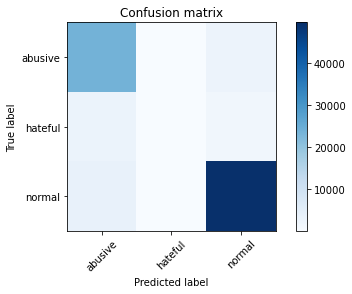

In [19]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_array)
print(cm)
plt.figure()
plot_confusion_matrix(cm, category)
plt.show()

# A/H Streaming Random Patches Model

In [20]:
from skmultiflow.meta import StreamingRandomPatchesClassifier
srp = StreamingRandomPatchesClassifier()

##### SRP Hyperparameter Tuning

In [15]:
srp_params = [{"subspace_mode":["percentage","m","sqrtM1","MsqrtM1"],
               "training_method":["randomsubspaces","resampling","randompatches"]}]
from sklearn.model_selection import ParameterGrid
srp_gs = ParameterGrid(srp_params)

In [16]:
len(srp_gs)

12

In [25]:
list(srp_gs)

"[{'subspace_mode': 'percentage', 'training_method': 'randomsubspaces'},\n {'subspace_mode': 'percentage', 'training_method': 'resampling'},\n {'subspace_mode': 'percentage', 'training_method': 'randompatches'},\n {'subspace_mode': 'm', 'training_method': 'randomsubspaces'},\n {'subspace_mode': 'm', 'training_method': 'resampling'},\n {'subspace_mode': 'm', 'training_method': 'randompatches'},\n {'subspace_mode': 'sqrtM1', 'training_method': 'randomsubspaces'},\n {'subspace_mode': 'sqrtM1', 'training_method': 'resampling'},\n {'subspace_mode': 'sqrtM1', 'training_method': 'randompatches'},\n {'subspace_mode': 'MsqrtM1', 'training_method': 'randomsubspaces'},\n {'subspace_mode': 'MsqrtM1', 'training_method': 'resampling'},\n {'subspace_mode': 'MsqrtM1', 'training_method': 'randompatches'}]"

In [27]:
#hyperparameter tuning
from sklearn import metrics
best_f1_score = 0
best_params = []
for params in srp_gs:
    ah_tweet_stream = DataStream(data = x_ah, y = y_ah.values, cat_features=[12,13])
    temp_srp = StreamingRandomPatchesClassifier()
    temp_srp.set_params(subspace_mode= params["subspace_mode"],
                        training_method = params["training_method"])
    print(params)
    y_true = []
    y_pred_array = []
    # Train the estimator with the samples provided by the data stream
    while ah_tweet_stream.has_more_samples():
        X, y = ah_tweet_stream.next_sample()
        y_true.append(y)
        y_pred = temp_srp.predict(X)
        y_pred_array.append(y_pred)
        temp_srp.partial_fit(X, y, classes = np.array([0,1,2]))
    #ah_tweet_stream = DataStream(data = x_ah, y = y_ah.values, cat_features=[12,13])
    temp_f1 = metrics.f1_score(y_true, y_pred_array, average='weighted')
    if temp_f1 >= best_f1_score:
        best_f1_score = temp_f1
        best_params = params

{'subspace_mode': 'percentage', 'training_method': 'randomsubspaces'}
{'subspace_mode': 'percentage', 'training_method': 'resampling'}


c:\Users\aztec\anaconda3\lib\site-packages\skmultiflow\drift_detection\adwin.py:350: RuntimeWarning: overflow encountered in int_scalars
  self.mdbl_width += self.width


{'subspace_mode': 'percentage', 'training_method': 'randompatches'}
{'subspace_mode': 'm', 'training_method': 'randomsubspaces'}


c:\Users\aztec\anaconda3\lib\site-packages\skmultiflow\drift_detection\adwin.py:350: RuntimeWarning: overflow encountered in int_scalars
  self.mdbl_width += self.width
c:\Users\aztec\anaconda3\lib\site-packages\skmultiflow\drift_detection\adwin.py:350: RuntimeWarning: overflow encountered in int_scalars
  self.mdbl_width += self.width
c:\Users\aztec\anaconda3\lib\site-packages\skmultiflow\drift_detection\adwin.py:350: RuntimeWarning: overflow encountered in int_scalars
  self.mdbl_width += self.width
c:\Users\aztec\anaconda3\lib\site-packages\skmultiflow\drift_detection\adwin.py:350: RuntimeWarning: overflow encountered in int_scalars
  self.mdbl_width += self.width
c:\Users\aztec\anaconda3\lib\site-packages\skmultiflow\drift_detection\adwin.py:350: RuntimeWarning: overflow encountered in int_scalars
  self.mdbl_width += self.width
c:\Users\aztec\anaconda3\lib\site-packages\skmultiflow\drift_detection\adwin.py:350: RuntimeWarning: overflow encountered in int_scalars
  self.mdbl_width 

{'subspace_mode': 'm', 'training_method': 'resampling'}


c:\Users\aztec\anaconda3\lib\site-packages\skmultiflow\drift_detection\adwin.py:350: RuntimeWarning: overflow encountered in int_scalars
  self.mdbl_width += self.width
c:\Users\aztec\anaconda3\lib\site-packages\skmultiflow\drift_detection\adwin.py:350: RuntimeWarning: overflow encountered in int_scalars
  self.mdbl_width += self.width


{'subspace_mode': 'm', 'training_method': 'randompatches'}


c:\Users\aztec\anaconda3\lib\site-packages\skmultiflow\drift_detection\adwin.py:350: RuntimeWarning: overflow encountered in int_scalars
  self.mdbl_width += self.width
c:\Users\aztec\anaconda3\lib\site-packages\skmultiflow\drift_detection\adwin.py:350: RuntimeWarning: overflow encountered in int_scalars
  self.mdbl_width += self.width


{'subspace_mode': 'sqrtM1', 'training_method': 'randomsubspaces'}


c:\Users\aztec\anaconda3\lib\site-packages\skmultiflow\drift_detection\adwin.py:350: RuntimeWarning: overflow encountered in int_scalars
  self.mdbl_width += self.width


{'subspace_mode': 'sqrtM1', 'training_method': 'resampling'}


c:\Users\aztec\anaconda3\lib\site-packages\skmultiflow\drift_detection\adwin.py:350: RuntimeWarning: overflow encountered in int_scalars
  self.mdbl_width += self.width


{'subspace_mode': 'sqrtM1', 'training_method': 'randompatches'}


c:\Users\aztec\anaconda3\lib\site-packages\skmultiflow\drift_detection\adwin.py:350: RuntimeWarning: overflow encountered in int_scalars
  self.mdbl_width += self.width


{'subspace_mode': 'MsqrtM1', 'training_method': 'randomsubspaces'}


c:\Users\aztec\anaconda3\lib\site-packages\skmultiflow\drift_detection\adwin.py:350: RuntimeWarning: overflow encountered in int_scalars
  self.mdbl_width += self.width


{'subspace_mode': 'MsqrtM1', 'training_method': 'resampling'}


c:\Users\aztec\anaconda3\lib\site-packages\skmultiflow\drift_detection\adwin.py:350: RuntimeWarning: overflow encountered in int_scalars
  self.mdbl_width += self.width
c:\Users\aztec\anaconda3\lib\site-packages\skmultiflow\drift_detection\adwin.py:350: RuntimeWarning: overflow encountered in int_scalars
  self.mdbl_width += self.width


{'subspace_mode': 'MsqrtM1', 'training_method': 'randompatches'}


In [28]:
best_params

{'subspace_mode': 'MsqrtM1', 'training_method': 'resampling'}

In [29]:
best_f1_score

0.8548149651455061

##### SRP Tweet Characteristic Model

In [21]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
y_true = []
y_pred_array = []
srp.set_params(subspace_mode = "MsqrtM1", training_method= "resampling")
ah_tweet_stream = DataStream(data = x_ah, y = y_ah.values, cat_features=[12,13])
# Train the estimator with the samples provided by the data stream
while ah_tweet_stream.has_more_samples():
    X, y = ah_tweet_stream.next_sample()
    y_true.append(y)
    y_pred = srp.predict(X)
    y_pred_array.append(y_pred)
    srp.partial_fit(X, y, classes = np.array([0,1,2]))

KeyboardInterrupt: 

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_true, y_pred_array))

              precision    recall  f1-score   support

           0       0.83      0.82      0.82     27141
           1       0.88      0.03      0.06      4963
           2       0.88      0.96      0.92     53650

    accuracy                           0.86     85754
   macro avg       0.86      0.60      0.60     85754
weighted avg       0.86      0.86      0.84     85754



In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_array)
print(cm)
plt.figure()
plot_confusion_matrix(cm, category)
plt.show()

# Aggressive Tweets

In [22]:
#combine abusive and hateful tweets into aggressive for later comparison with other work
aggressive_tweets = ah_tweets_copy
aggressive_tweets = aggressive_tweets.replace("abusive","aggressive")
aggressive_tweets = aggressive_tweets.replace("hateful","aggressive")
aggressive_tweets

,Tweet text,Label,@ count,Hashtag count,Retweet,Url count,Uppercase word count,Num sentences,Avg sentence len,Sentiment,Adjective count,Verb count,Adverb count,Profanity count,Avg word len
1,Man it would fucking rule if we had a party ...,aggressive,1,0,True,0,0,1,16.0,0.1280,1,3,0,1,4.266667
2,It is time to draw close to Him Father I draw...,normal,0,2,False,1,1,1,20.0,0.0000,0,4,3,0,3.294118
3,if you notice me start to act different or dis...,normal,0,0,False,0,0,1,35.0,0.0000,5,8,0,0,3.633333
4,Forget unfollowers I believe in growing new f...,normal,0,0,False,1,1,3,6.0,-0.1260,3,1,0,0,4.714286
5,Hate Being sexually Frustrated Like I wanna ...,aggressive,1,0,True,0,1,1,16.0,-0.8689,0,2,1,3,4.785714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99991,my fucking queen,aggressive,1,0,True,1,0,1,3.0,0.0000,0,0,0,1,4.666667
99992,treated with rebuild bone mass,normal,0,3,False,2,0,1,7.0,0.0000,0,1,0,0,5.200000
99993,why does my phone screen keeps flickring im s...,normal,1,4,False,0,0,1,29.0,-0.9430,4,4,2,1,3.576923
99994,vs but equally applies to any project,normal,0,3,False,2,0,1,8.0,0.0000,0,0,1,0,4.428571


In [23]:
#check to make sure only aggressive and normal tweet labels exist
pd.unique(aggressive_tweets['Label'])

array(['aggressive', 'normal'], dtype=object)

In [24]:
aggressive_tweets.drop(aggressive_tweets.columns[[0]], axis=1, inplace=True)
category = encode_text_index(aggressive_tweets, "Label")
#'aggressive' tweets label = 0
#'normal' tweets label = 1
encode_numeric_zscore(aggressive_tweets, "@ count")
encode_numeric_zscore(aggressive_tweets, "Hashtag count")
encode_text_dummy(aggressive_tweets, "Retweet")
encode_numeric_zscore(aggressive_tweets, "Url count")
encode_numeric_zscore(aggressive_tweets, "Uppercase word count")
encode_numeric_zscore(aggressive_tweets, "Num sentences")
encode_numeric_zscore(aggressive_tweets, "Adjective count")
encode_numeric_zscore(aggressive_tweets, "Verb count")
encode_numeric_zscore(aggressive_tweets, "Adverb count")
encode_numeric_zscore(aggressive_tweets, "Profanity count")
aggressive_tweets

,Label,@ count,Hashtag count,Url count,Uppercase word count,Num sentences,Avg sentence len,Sentiment,Adjective count,Verb count,Adverb count,Profanity count,Avg word len,Retweet-False,Retweet-True
1,0,0.220582,-0.392741,-1.026551,-0.402188,-0.632783,16.0,0.1280,-0.067988,0.163446,-0.696501,0.327584,4.266667,0,1
2,1,-0.700879,0.862444,0.558705,-0.008264,-0.632783,20.0,0.0000,-0.965360,0.695128,2.521878,-0.712615,3.294118,1,0
3,1,-0.700879,-0.392741,-1.026551,-0.402188,-0.632783,35.0,0.0000,3.521502,2.821852,-0.696501,-0.712615,3.633333,1,0
4,1,-0.700879,-0.392741,0.558705,-0.008264,1.782263,6.0,-0.1260,1.726757,-0.899916,-0.696501,-0.712615,4.714286,1,0
5,0,0.220582,-0.392741,-1.026551,-0.008264,-0.632783,16.0,-0.8689,-0.965360,-0.368235,0.376292,2.407981,4.785714,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99991,0,0.220582,-0.392741,0.558705,-0.402188,-0.632783,3.0,0.0000,-0.965360,-1.431597,-0.696501,0.327584,4.666667,0,1
99992,1,-0.700879,1.490037,2.143961,-0.402188,-0.632783,7.0,0.0000,-0.965360,-0.899916,-0.696501,-0.712615,5.200000,1,0
99993,1,0.220582,2.117630,-1.026551,-0.402188,-0.632783,29.0,-0.9430,2.624130,0.695128,1.449085,0.327584,3.576923,1,0
99994,1,-0.700879,1.490037,2.143961,-0.402188,-0.632783,8.0,0.0000,-0.965360,-1.431597,0.376292,-0.712615,4.428571,1,0


# Create Aggressive Tweets Data Stream

In [25]:
x_agg = aggressive_tweets.iloc[:,1:]
y_agg = aggressive_tweets['Label']
x_train_agg, x_test_agg, y_train_agg, y_test_agg = train_test_split(x_agg, y_agg, test_size=0.3, random_state=42)

'x_train_agg = list(filter(None, x_train_agg.to_csv(index=False).split("\n")[1:]))\ny_train_agg = list(filter(None, y_train_agg.to_csv(index=False).split("\n")[1:]))\n\nx_test_agg = list(filter(None, x_test_agg.to_csv(index=False).split("\n")[1:]))\ny_test_agg = list(filter(None, y_test_agg.to_csv(index=False).split("\n")[1:]))'

# Agg Extremely Fast Decision Tree Model

##### Agg EFDT Tweet Characteristic Model

In [26]:
agg_efdt = ExtremelyFastDecisionTreeClassifier()
agg_efdt.set_params(grace_period = 500, split_criterion='info_gain',
        split_confidence=.1, tie_threshold=.075,
        leaf_prediction='mc', min_samples_reevaluate=20,
        nominal_attributes=[12,13])
agg_tweet_stream = DataStream(data = x_agg, y = y_agg.values, cat_features=[12,13])
y_true = []
y_pred_array = []
# Train the estimator with the samples provided by the data stream
while agg_tweet_stream.has_more_samples():
    X, y = agg_tweet_stream.next_sample()
    y_true.append(y)
    y_pred = agg_efdt.predict(X)
    y_pred_array.append(y_pred)
    agg_efdt.partial_fit(X, y)

In [27]:
from sklearn import metrics
print(metrics.classification_report(y_true, y_pred_array))

              precision    recall  f1-score   support

           0       0.84      0.89      0.86     32104
           1       0.93      0.90      0.91     53650

    accuracy                           0.89     85754
   macro avg       0.88      0.89      0.89     85754
weighted avg       0.90      0.89      0.89     85754



[[28641  3463]
 [ 5595 48055]]


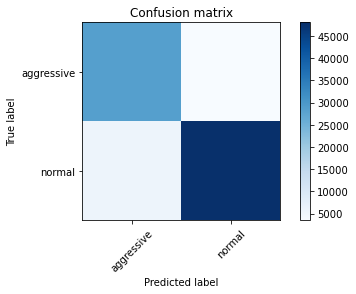

In [28]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_array)
print(cm)
plt.figure()
plot_confusion_matrix(cm, category)
plt.show()

# Agg Hoeffding Adaptive Tree Model

##### Agg HAT Tweet Characteristic Model

In [29]:
agg_tweet_stream = DataStream(data = x_agg, y = y_agg.values, cat_features=[12,13])
agg_hat = HoeffdingAdaptiveTreeClassifier()
agg_hat.set_params(grace_period = 500, split_criterion='info_gain',
        split_confidence=.1, tie_threshold=.075,
        leaf_prediction='nba',nominal_attributes=[12,13])
y_true = []
y_pred_array = []
# Train the estimator with the samples provided by the data stream
while agg_tweet_stream.has_more_samples():
    X, y = agg_tweet_stream.next_sample()
    y_true.append(y)
    y_pred = agg_hat.predict(X)
    y_pred_array.append(y_pred)
    agg_hat.partial_fit(X, y)

In [30]:
from sklearn import metrics
print(metrics.classification_report(y_true, y_pred_array))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87     32104
           1       0.93      0.91      0.92     53650

    accuracy                           0.90     85754
   macro avg       0.89      0.90      0.89     85754
weighted avg       0.90      0.90      0.90     85754



[[28262  3842]
 [ 4751 48899]]


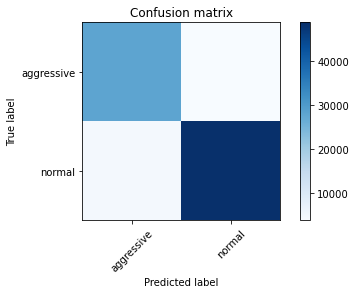

In [31]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_array)
print(cm)
plt.figure()
plot_confusion_matrix(cm, category)
plt.show()

# Agg Streaming Random Patches Model

##### Agg SRP Tweet Characteristic Model

In [ ]:
agg_tweet_stream = DataStream(data = x_agg, y = y_agg.values, cat_features=[12,13])
agg_srp = StreamingRandomPatchesClassifier()
agg_srp.set_params(subspace_mode = "MsqrtM1", training_method= "resampling")
y_true = []
y_pred_array = []
# Train the estimator with the samples provided by the data stream
while agg_tweet_stream.has_more_samples():
    X, y = agg_tweet_stream.next_sample()
    y_true.append(y)
    y_pred = agg_srp.predict(X)
    y_pred_array.append(y_pred)
    agg_srp.partial_fit(X, y, classes = np.array([0,1,2]))

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_true, y_pred_array))

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_array)
print(cm)
plt.figure()
plot_confusion_matrix(cm, category)
plt.show()